### Install jupytext for notebook version control

In [3]:
%%bash
pip install --upgrade pip
pip install jupytext

  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1


### Download Stack Overflow questions dataset from Kaggle

In [7]:
%%bash
pip install kaggle --upgrade

  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72866 sha256=2e0a8668af01b5d745915b8442f8bf1f93c1e36a46cabcc17330f98abe757a7f
  Stored in directory: /home/ec2-user/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
  Created wheel for python-slugify: filename=python_slugify-4.0.0-py2.py3-none-any.whl size=4653 sha256=c4693b0982228bf72d45835b25b76354ef03b2c567343def23559eceece460f7
  Stored in directory: /home/ec2-user/.cache/pip/wheels/11/94/81/312969455540cb0e6a773e5d68a73c14128bfdfd4a7969bb4f
Successfully built kaggle python-slugify


In [19]:
%%bash
kaggle datasets download -d stackoverflow/stacksample --force

100%|██████████| 1.11G/1.11G [00:22<00:00, 53.4MB/s]


In [24]:
%%bash
unzip /home/ec2-user/SageMaker/stack-overflow-questions-auto-tagger/stacksample.zip -d data

Archive:  /home/ec2-user/SageMaker/stack-overflow-questions-auto-tagger/stacksample.zip
  inflating: data/Answers.csv        
  inflating: data/Questions.csv      
  inflating: data/Tags.csv           


### Exploratory Data Analysis

In [1]:
import os

HOME_DIR = os.curdir
DATA_DIR = os.path.join(HOME_DIR, "data")

In [2]:
%%bash
pip install --upgrade pip
pip install seaborn==0.9.0

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (19.3.1)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_colwidth = 255
sns.set(style="darkgrid")

#### Questions

In [66]:
%%time
questions_df = pd.read_csv(os.path.join(DATA_DIR, "Questions.csv"), encoding="ISO-8859-1", parse_dates=["CreationDate", "ClosedDate"])

CPU times: user 21.3 s, sys: 1.18 s, total: 22.5 s
Wall time: 21.3 s


In [68]:
print(f"Number of rows: {questions_df.shape[0]}")
print(f"Number of columns: {questions_df.shape[1]}")

Number of rows: 1264216
Number of columns: 7


In [69]:
questions_df.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01 13:57:07+00:00,NaT,26,SQLStatement.execute() - multiple queries in one statement,"<p>I've written a database generation script in <a href=""http://en.wikipedia.org/wiki/SQL"">SQL</a> and want to execute it in my <a href=""http://en.wikipedia.org/wiki/Adobe_Integrated_Runtime"">Adobe AIR</a> application:</p>\n\n<pre><code>Create Table t..."
1,90,58.0,2008-08-01 14:41:24+00:00,2012-12-26 03:45:49+00:00,144,Good branching and merging tutorials for TortoiseSVN?,"<p>Are there any really good tutorials explaining <a href=""http://svnbook.red-bean.com/en/1.8/svn.branchmerge.html"" rel=""nofollow"">branching and merging</a> with Apache Subversion? </p>\n\n<p>All the better if it's specific to TortoiseSVN client.</p>\n"
2,120,83.0,2008-08-01 15:50:08+00:00,NaT,21,ASP.NET Site Maps,"<p>Has anyone got experience creating <strong>SQL-based ASP.NET</strong> site-map providers?</p>\n\n<p>I've got the default XML file <code>web.sitemap</code> working properly with my Menu and <strong>SiteMapPath</strong> controls, but I'll need a way ..."
3,180,2089740.0,2008-08-01 18:42:19+00:00,NaT,53,Function for creating color wheels,"<p>This is something I've pseudo-solved many times and never quite found a solution. That's stuck with me. The problem is to come up with a way to generate <code>N</code> colors, that are as distinguishable as possible where <code>N</code> is a parame..."
4,260,91.0,2008-08-01 23:22:08+00:00,NaT,49,Adding scripting functionality to .NET applications,"<p>I have a little game written in C#. It uses a database as back-end. It's \na <a href=""http://en.wikipedia.org/wiki/Collectible_card_game"">trading card game</a>, and I wanted to implement the function of the cards as a script.</p>\n\n<p>What I mean ..."


We can see that `Title` is in plain text, while `Body` is in HTML format, which requires a lot of data cleansing before it is in a useful format. Also note that punctuations can be meaningful in this problem, e.g. `ASP.NET`, `C#`, etc, so we need to be careful not to remove them during data cleansing.

#### Tags

In [70]:
%%time
tags_df = pd.read_csv(os.path.join(DATA_DIR, "Tags.csv"), encoding="ISO-8859-1")

CPU times: user 2.9 s, sys: 196 ms, total: 3.1 s
Wall time: 1.1 s


In [71]:
print(f"Number of rows: {tags_df.shape[0]}")
print(f"Number of columns: {tags_df.shape[1]}")

Number of rows: 3750994
Number of columns: 2


In [72]:
tags_df.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


`Questions` has a one-to-many relationship with `Tags`, as there is only one question ID and tag pair in each record.

### Top 10 tags with most questions

In [10]:
tag_value_counts = tags_df["Tag"].value_counts()

In [11]:
top_ten_tags = tag_value_counts.head(10)
top_ten_tags

javascript    124155
java          115212
c#            101186
php            98808
android        90659
jquery         78542
python         64601
html           58976
c++            47591
ios            47009
Name: Tag, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

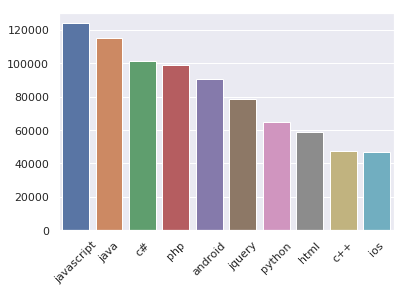

In [12]:
sns.barplot(x=top_ten_tags.index, y=top_ten_tags.values)
plt.xticks(rotation=45)

### Top 50 tags with most questions

In [13]:
top_fifty_tags = tag_value_counts.head(50)
top_fifty_tags

javascript        124155
java              115212
c#                101186
php                98808
android            90659
jquery             78542
python             64601
html               58976
c++                47591
ios                47009
mysql              42464
css                42308
sql                35782
asp.net            29970
objective-c        26922
ruby-on-rails      25789
.net               24059
c                  23238
iphone             21539
angularjs          20345
arrays             19799
sql-server         18160
json               17669
ruby               17013
r                  15701
ajax               15629
regex              15349
xml                14763
node.js            14525
asp.net-mvc        14284
linux              13395
django             12818
wpf                12365
database           11860
swift              11832
xcode              10633
string             10427
excel              10384
vb.net             10286
windows            10142


#### Let's plot the counts to have a better visualization about the distribution:

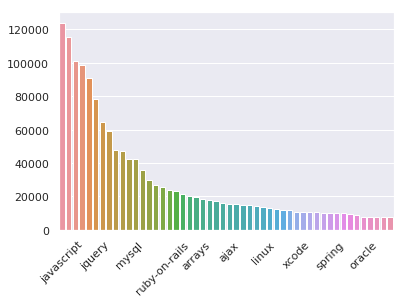

In [14]:
top_fifty_tags_barplot = sns.barplot(x=top_fifty_tags.index, y=top_fifty_tags.values)
for i, label in enumerate(top_fifty_tags_barplot.xaxis.get_ticklabels()):
    if i % 5 != 0:
        label.set_visible(False)
plt.xticks(rotation=45)
top_fifty_tags_barplot

We can see that the number of questions per tag clearly demostrates a long tail distribution. Therefore, we can limit the number of tags to include in the dataset, so that the model training can be more efficient, while still maintain a high level of accuracy.

In [54]:
pd.options.display.float_format = "{:.2f}%".format
100 * tag_value_counts.head(4000).cumsum() / tag_value_counts.sum()

javascript            3.31%
java                  6.38%
c#                    9.08%
php                  11.72%
android              14.13%
jquery               16.23%
python               17.95%
html                 19.52%
c++                  20.79%
ios                  22.05%
mysql                23.18%
css                  24.31%
sql                  25.26%
asp.net              26.06%
objective-c          26.78%
ruby-on-rails        27.47%
.net                 28.11%
c                    28.73%
iphone               29.30%
angularjs            29.85%
arrays               30.37%
sql-server           30.86%
json                 31.33%
ruby                 31.78%
r                    32.20%
ajax                 32.62%
regex                33.03%
xml                  33.42%
node.js              33.81%
asp.net-mvc          34.19%
                      ...  
mediaelement.js      89.89%
tortoisegit          89.89%
zoo                  89.89%
gpuimage             89.89%
factorial           

The top 4000 tags cover almost 90% of the questions in the dataset. Therefore, I will limit the dataset to include only questions with the top 4000 tags to reduce the size and time for model training. We can always include more tags later in case we find the model is not as performant as expected.

#### Joining `Questions` with `Tags`

In [73]:
# standardize column names
for df in [questions_df, tags_df]:
    df.columns = df.columns.str.lower()

In [40]:
%%time
# group rows per question id
tags_per_question_df = tags_df.groupby(['id'])['tag'].apply(list)

CPU times: user 1min 42s, sys: 200 ms, total: 1min 42s
Wall time: 1min 41s


In [41]:
tags_per_question_df.head()

id
80                             [flex, actionscript-3, air]
90       [svn, tortoisesvn, branch, branching-and-merging]
120                                [sql, asp.net, sitemap]
180    [algorithm, language-agnostic, colors, color-space]
260           [c#, .net, scripting, compiler-construction]
Name: tag, dtype: object

In [92]:
%%time
# we are only interested in text column from `questions_df`
df = questions_df[["id", "title", "body"]].merge(tags_per_question_df.to_frame(), on="id")

CPU times: user 1.49 s, sys: 33.9 ms, total: 1.53 s
Wall time: 484 ms


In [93]:
df["tag_count"] = df["tag"].apply(len)

In [94]:
df.head()

,id,title,body,tag,tag_count
0,80,SQLStatement.execute() - multiple queries in one statement,"<p>I've written a database generation script in <a href=""http://en.wikipedia.org/wiki/SQL"">SQL</a> and want to execute it in my <a href=""http://en.wikipedia.org/wiki/Adobe_Integrated_Runtime"">Adobe AIR</a> application:</p>\n\n<pre><code>Create Table t...","[flex, actionscript-3, air]",3
1,90,Good branching and merging tutorials for TortoiseSVN?,"<p>Are there any really good tutorials explaining <a href=""http://svnbook.red-bean.com/en/1.8/svn.branchmerge.html"" rel=""nofollow"">branching and merging</a> with Apache Subversion? </p>\n\n<p>All the better if it's specific to TortoiseSVN client.</p>\n","[svn, tortoisesvn, branch, branching-and-merging]",4
2,120,ASP.NET Site Maps,"<p>Has anyone got experience creating <strong>SQL-based ASP.NET</strong> site-map providers?</p>\n\n<p>I've got the default XML file <code>web.sitemap</code> working properly with my Menu and <strong>SiteMapPath</strong> controls, but I'll need a way ...","[sql, asp.net, sitemap]",3
3,180,Function for creating color wheels,"<p>This is something I've pseudo-solved many times and never quite found a solution. That's stuck with me. The problem is to come up with a way to generate <code>N</code> colors, that are as distinguishable as possible where <code>N</code> is a parame...","[algorithm, language-agnostic, colors, color-space]",4
4,260,Adding scripting functionality to .NET applications,"<p>I have a little game written in C#. It uses a database as back-end. It's \na <a href=""http://en.wikipedia.org/wiki/Collectible_card_game"">trading card game</a>, and I wanted to implement the function of the cards as a script.</p>\n\n<p>What I mean ...","[c#, .net, scripting, compiler-construction]",4


#### Minimum, maximum and average tags per question

In [95]:
min_tag_count = df["tag_count"].min()
max_tag_count = df["tag_count"].max()
avg_tag_count = df["tag_count"].mean()

In [96]:
print(f"Each question has a minimum of {min_tag_count} tag and a maximum of {max_tag_count} tags. \
The average number of tags per question is {avg_tag_count:.2f}.")

Each question has a minimum of 1 tag and a maximum of 5 tags. The average number of tags per question is 2.97.
